# Homework Week 9
23160004 Tae-Hyoung Kim

In [1]:
from DELCgen import *
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from scipy import stats as st
from scipy import interpolate
from astropy.modeling import models, fitting
import pandas as pd
import numpy as np
import readline
import os
import sys

In [2]:
def SPL(v, alpha1, b1):
    return 10**(np.log10(v)*alpha1 + np.log10(b1))

def CPL(v, alpha1, alpha2, b1):
    return 10**(alpha1*np.log10(v)**2 + alpha2*np.log10(v) + np.log10(b1))

def BPL(v, A, v_bend, a_high, c):
    p = BendingPL(v,A,v_bend,1.1,a_high,c)
    return p


def simLC(path_datafile, path_output, mode='original',paramsSPL=[1,-1],paramsBPL=[1,1,1,1],paramsCPL=[1,1,1],fit_original=False,create_arbitrary=True):

    # python2 version of simulating LC
    # in case Jeff's workaround for py3 doesn't work

    # mode = original, simplePL, brokenPL, curvedPL
    
    #------- Input parameters -------

    # File Route

    # org_time, org_flux = np.genfromtxt(path_datafile, usecols=(0,1), unpack=True)

    # Bending power law params
    A,v_bend,a_low,a_high,c = 0.03, 2.3e-4, 1.1, 2.2, 0.009

    # Probability density function params
    kappa,theta,lnmu,lnsig,weight = 5.67, 5.96, 2.14, 0.31,0.82
    # Simulation pa
    RedNoiseL,aliasTbin, RandomSeed, tbin = 100,1,6501,7

    #--------- Commands ---------------

    # load data lightcurve
    datalc = Load_Lightcurve(path_datafile,tbin)

    # create mixture distribution to fit to PDF
    mix_model = Mixture_Dist([st.gamma,st.lognorm],[3,3],[[[2],[0]],[[2],[0],]])


    # estimate underlying variance of data light curve

    if(mode=='original'):
        delc = datalc.Simulate_DE_Lightcurve()

    else:

        if(mode=='simplePL'):
            initials = [1,1]
            def model(v, alpha1, b1):
                return 10**(np.log10(v)*alpha1 + np.log10(b1))

        if(mode=='brokenPL'):
            initials = [1,1,1,1]
            def model(v,A,v_bend,a_high,c):
                p = BendingPL(v,A,v_bend,1.1,a_high,c)
                return p

        if(mode=='curvedPL'):
            initials = [1,1,1]
            def model(v, alpha1, alpha2, b1):
                return 10**(alpha1*np.log10(v)**2 + alpha2*np.log10(v) + np.log10(b1))

        # datalc.Fit_PSD(initial_params=initials,model=model)
        # datalc.Fit_PDF(initial_params=[kappa,theta,lnmu,lnsig,weight],model=mix_model )
        # datalc.STD_Estimate()
        # delc = Simulate_DE_Lightcurve(model,lightcurve=datalc)
        if fit_original == True:
            delc = datalc.Simulate_DE_Lightcurve()
        elif create_arbitrary == True:
            if(mode=='simplePL'):
                # print(datalc.pdfFit[s'x'][0])
                #delc = datalc.Simulate_DE_Lightcurve(model,(paramsSPL[0],paramsSPL[1]))
                print(paramsSPL)
                print(model)
                surrogate, PSDlast, shortLC, periodogram, fft = EmmanLC(datalc.time, RedNoiseL,aliasTbin,RandomSeed, tbin, PSDmodel=SPL, PSDparams=paramsSPL,
                                                PDFmodel=mix_model, PDFparams=[kappa,theta,lnmu,lnsig,weight])
                ## surrogate[0] = simulated time, surrogate[1] = simulated flux
                ## PSDLast[0] = simulated freq, PSDLast[1] = simulated power
                ax1 = plt.subplot(121)
                ax2 = plt.subplot(122)
                ax1.plot(surrogate[0],surrogate[1],label="Simulated LC")
                ax2.plot(np.log10(PSDlast[0]),np.log10(PSDlast[1]),label="Simulated PSD")
                plt.legend()
                plt.show()
                return PSDlast

            if(mode=='brokenPL'):
                # print(datalc.pdfFit[s'x'][0])
                #delc = datalc.Simulate_DE_Lightcurve(model,(paramsSPL[0],paramsSPL[1]))
                print(paramsBPL)
                print(model)
                surrogate, PSDlast, shortLC, periodogram, fft = EmmanLC(datalc.time, RedNoiseL,aliasTbin,RandomSeed, tbin, PSDmodel=BPL, PSDparams=paramsBPL,
                                                PDFmodel=mix_model, PDFparams=[kappa,theta,lnmu,lnsig,weight])
                ## surrogate[0] = simulated time, surrogate[1] = simulated flux
                ## PSDLast[0] = simulated freq, PSDLast[1] = simulated power
                ax1 = plt.subplot(121)
                ax2 = plt.subplot(122)
                ax1.plot(surrogate[0],surrogate[1],label="Simulated LC")
                ax2.plot(np.log10(PSDlast[0]),np.log10(PSDlast[1]),label="Simulated PSD")
                plt.show()
                return PSDlast
            
            if(mode=='curvedPL'):
                # print(datalc.pdfFit[s'x'][0])
                #delc = datalc.Simulate_DE_Lightcurve(model,(paramsSPL[0],paramsSPL[1]))
                print(paramsCPL)
                print(model)
                surrogate, PSDlast, shortLC, periodogram, fft = EmmanLC(datalc.time, RedNoiseL,aliasTbin,RandomSeed, tbin, PSDmodel=CPL, PSDparams=paramsCPL,
                                                PDFmodel=mix_model, PDFparams=[kappa,theta,lnmu,lnsig,weight])
                ## surrogate[0] = simulated time, surrogate[1] = simulated flux
                ## PSDLast[0] = simulated freq, PSDLast[1] = simulated power
                ax1 = plt.subplot(121)
                ax2 = plt.subplot(122)
                ax1.plot(surrogate[0],surrogate[1],label="Simulated LC")
                ax2.plot(np.log10(PSDlast[0]),np.log10(PSDlast[1]),label="Simulated PSD")
                plt.show()
                return PSDlast

    
    # save the simulated light curve as a txt file
    # delc.Save_Lightcurve(path_output)

path_datafile = "./filtered.csv"
path_output   = "./test.lc"
#mode = "simplePL"

print(path_datafile)

./filtered.csv


In [3]:
def logSPL(v, alpha1, b1):
    return np.log10(v)*alpha1 + np.log10(b1)

def logCPL(v, alpha1, alpha2, b1):
    return alpha1*np.log10(v)**2 + alpha2*np.log10(v) + np.log10(b1)

# 1) Simple Power Law

Read 730 lines of data
[1, 1]
<function model at 0x7f1dd633fed0>


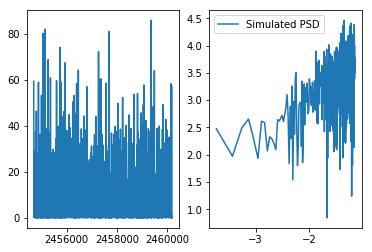

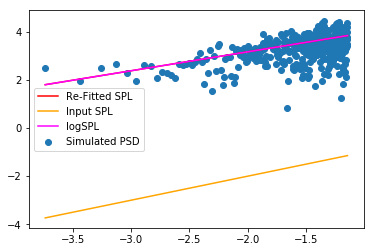

('In =', 1, 1)
('Out=', 0.7878066998229315, 55251.4611222182)
('Out=', 0.6680058764722429, 20947.22054280136)


In [5]:
PSDparams=[1,1]
PSD = simLC(path_datafile, path_output, mode='simplePL', paramsSPL = PSDparams)
logPSD = np.log10(PSD)

Fitparams, cov = curve_fit(SPL, PSD[0], PSD[1], p0=PSDparams)
logFitparams, logcov = curve_fit(logSPL, PSD[0], logPSD[1], p0=PSDparams)

plt.scatter(logPSD[0], logPSD[1], label='Simulated PSD')
plt.plot(logPSD[0], np.log10(SPL(PSD[0], Fitparams[0], Fitparams[1])), label='Re-Fitted SPL', color='red')
plt.plot(logPSD[0], np.log10(SPL(PSD[0], PSDparams[0], PSDparams[1])), label='Input SPL', color='orange')
plt.plot(logPSD[0], logSPL(PSD[0], Fitparams[0], Fitparams[1]), label='logSPL', color='magenta')
plt.legend()
plt.show()

print('In =', PSDparams[0], PSDparams[1])
print('Out=', Fitparams[0], Fitparams[1])
print('Out=', logFitparams[0], logFitparams[1])

In [6]:
'''
PSDparams=[3,20]

PSD = simLC(path_datafile, path_output, mode='simplePL', paramsSPL = PSDparams)

Fitparams, cov = curve_fit(SPL, PSD[0], PSD[1])

plt.scatter(np.log10(PSD[0]), np.log10(PSD[1]), label='Simulated PSD')
plt.plot(np.log10(PSD[0]), np.log10(SPL(PSD[0], Fitparams[0], Fitparams[1])), label='Re-Fitted SPL', color='red')
plt.plot(np.log10(PSD[0]), np.log10(SPL(PSD[0], PSDparams[0], PSDparams[1])), label='Input SPL', color='orange')
plt.legend()
plt.show()
print('In =', PSDparams[0], PSDparams[1])
print('Out=', Fitparams[0], Fitparams[1])
'''

"\nPSDparams=[3,20]\n\nPSD = simLC(path_datafile, path_output, mode='simplePL', paramsSPL = PSDparams)\n\nFitparams, cov = curve_fit(SPL, PSD[0], PSD[1])\n\nplt.scatter(np.log10(PSD[0]), np.log10(PSD[1]), label='Simulated PSD')\nplt.plot(np.log10(PSD[0]), np.log10(SPL(PSD[0], Fitparams[0], Fitparams[1])), label='Re-Fitted SPL', color='red')\nplt.plot(np.log10(PSD[0]), np.log10(SPL(PSD[0], PSDparams[0], PSDparams[1])), label='Input SPL', color='orange')\nplt.legend()\nplt.show()\nprint('In =', PSDparams[0], PSDparams[1])\nprint('Out=', Fitparams[0], Fitparams[1])\n"

# 2) Broken Power Law

Read 730 lines of data
[1, 1, 1, 1]
<function model at 0x7f1dd5f556d0>


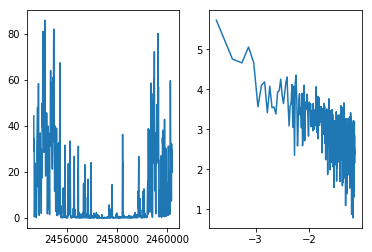

/home/taehyoung/.local/lib/python2.7/site-packages/scipy/optimize/minpack.py:791: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/taehyoung/.local/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  


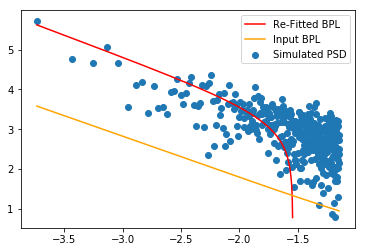

('In =', 1, 1, 1, 1)
('Out=', 32.69178705344877, 5727.059116912882, 79.37817020610896, -1631.3073742984807)


In [7]:
PSDparams=[1,1,1,1]

PSD = simLC(path_datafile, path_output, mode='brokenPL', paramsBPL = PSDparams)

Fitparams, cov = curve_fit(BPL, PSD[0], PSD[1], p0=PSDparams, maxfev = 10000)

plt.scatter(np.log10(PSD[0]), np.log10(PSD[1]), label='Simulated PSD')
plt.plot(np.log10(PSD[0]), np.log10(BPL(PSD[0], Fitparams[0], Fitparams[1], Fitparams[2], Fitparams[3])), label='Re-Fitted BPL', color='red')
plt.plot(np.log10(PSD[0]), np.log10(BPL(PSD[0], PSDparams[0], PSDparams[1], PSDparams[2], PSDparams[3])), label='Input BPL', color='orange')
plt.legend()
plt.show()
print('In =', PSDparams[0], PSDparams[1], PSDparams[2], PSDparams[3])
print('Out=', Fitparams[0], Fitparams[1], Fitparams[2], Fitparams[3])

# 3) Curved Power Law

Read 730 lines of data
[1, 1, 1]
<function model at 0x7f1dd5f55750>


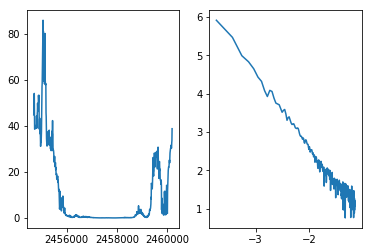

/home/taehyoung/.local/lib/python2.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log10
  """


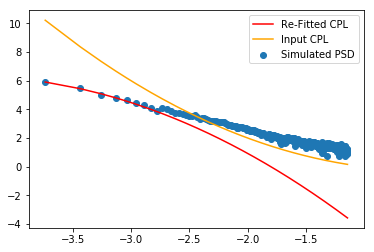

('In =', 1, 1, 1)
('Out=', -0.9232750411276952, -8.16818702920274, 1.911457234771099e-12)


In [9]:
PSDparams=[1,1,1]

PSD = simLC(path_datafile, path_output, mode='curvedPL', paramsCPL = PSDparams)

Fitparams, cov = curve_fit(CPL, PSD[0], PSD[1], p0=PSDparams, maxfev = 10000)

plt.scatter(np.log10(PSD[0]), np.log10(PSD[1]), label='Simulated PSD')
plt.plot(np.log10(PSD[0]), np.log10(CPL(PSD[0], Fitparams[0], Fitparams[1], Fitparams[2])), label='Re-Fitted CPL', color='red')
plt.plot(np.log10(PSD[0]), np.log10(CPL(PSD[0], PSDparams[0], PSDparams[1], PSDparams[2])), label='Input CPL', color='orange')
plt.legend()
plt.show()
print('In =', PSDparams[0], PSDparams[1], PSDparams[2])
print('Out=', Fitparams[0], Fitparams[1], Fitparams[2])

Read 730 lines of data
[1, 2, 4]
<function model at 0x7f1dd5f55ed0>


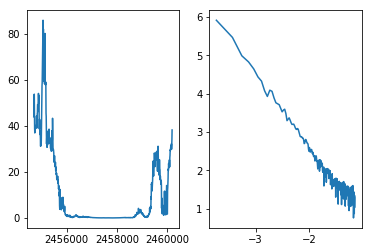

/home/taehyoung/.local/lib/python2.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log10
  """


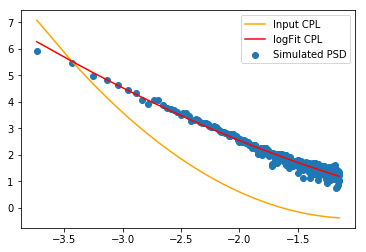

('In =', 1, 2, 4)
('Out=', 6.136747886666271, 39.96271992078557, 646.2041593649357)
('Out=', 0.21852380645747668, -0.8949511625723624, 0.7615749985349788)


In [10]:
PSDparams=[1,2,4]

PSD = simLC(path_datafile, path_output, mode='curvedPL', paramsCPL = PSDparams)
logPSD=np.log10(PSD)

Fitparams, cov = curve_fit(CPL, PSD[0], PSD[1], p0=PSDparams, maxfev = 10000)
logFitparams, logcov = curve_fit(logCPL, PSD[0], logPSD[1], p0=PSDparams, maxfev = 10000)


plt.scatter(np.log10(PSD[0]), np.log10(PSD[1]), label='Simulated PSD')
#plt.plot(np.log10(PSD[0]), np.log10(CPL(PSD[0], Fitparams[0], Fitparams[1], Fitparams[2])), label='Re-Fitted CPL', color='red')
plt.plot(np.log10(PSD[0]), np.log10(CPL(PSD[0], PSDparams[0], PSDparams[1], PSDparams[2])), label='Input CPL', color='orange')
plt.plot(logPSD[0], logCPL(PSD[0], logFitparams[0], logFitparams[1], logFitparams[2]), label='logFit CPL', color='red')
plt.legend()
plt.show()
print('In =', PSDparams[0], PSDparams[1], PSDparams[2])
print('Out=', Fitparams[0], Fitparams[1], Fitparams[2])
print('Out=', logFitparams[0], logFitparams[1], logFitparams[2])